<h1 align="center">
  Image Deconvolution Processes for Laminar Axisymmetrical Coflow Flames Using Artificial Neural Networks
</h1>

<p>
  This notebook contains the pre-trained neural network models for multiple input/output pairs and a test dataset for validation purposes.
</p>

<h2>
  Configuration
</h2>

<p>
  Modify the next cell according to one of the following valid input/output pairs (comment out the INPUT2 variable to disable it)
</p>

<br>

<div style="float:left; width:50%">
  <table>
    <tr>
      <th style="text-align:center">INPUT1</th>
      <th style="text-align:center">INPUT2</th>
      <th style="text-align:center">OUTPUT</th>
    </tr>
    <tr>
      <td style="text-align:center">tau1</td>
      <td style="text-align:center">-</td>
      <td style="text-align:center">k1</td>
    </tr>
    <tr>
      <td style="text-align:center">tau1</td>
      <td style="text-align:center">-</td>
      <td style="text-align:center">fs</td>
    </tr>
    <tr>
      <td style="text-align:center">tau2</td>
      <td style="text-align:center">-</td>
      <td style="text-align:center">k2</td>
    </tr>
    <tr>
      <td style="text-align:center">tau2</td>
      <td style="text-align:center">-</td>
      <td style="text-align:center">fs</td>
    </tr>
    <tr>
      <td style="text-align:center">tau1</td>
      <td style="text-align:center">tau2</td>
      <td style="text-align:center">fs</td>
    </tr>
  </table>
</div>

<div style="float:right; width:50%">
  <table>
    <tr>
      <th style="text-align:center">INPUT1</th>
      <th style="text-align:center">INPUT2</th>
      <th style="text-align:center">OUTPUT</th>
    </tr>
    <tr>
      <td style="text-align:center">py1</td>
      <td style="text-align:center">-</td>
      <td style="text-align:center">j1</td>
    </tr>
    <tr>
      <td style="text-align:center">py1</td>
      <td style="text-align:center">-</td>
      <td style="text-align:center">ts</td>
    </tr>
    <tr>
      <td style="text-align:center">py2</td>
      <td style="text-align:center">-</td>
      <td style="text-align:center">j2</td>
    </tr>
    <tr>
      <td style="text-align:center">py2</td>
      <td style="text-align:center">-</td>
      <td style="text-align:center">ts</td>
    </tr>
    <tr>
      <td style="text-align:center">py1</td>
      <td style="text-align:center">py2</td>
      <td style="text-align:center">ts</td>
    </tr>
  </table>
</div>

<br>

<p>
  and select a noise level for the inputs $\tau$ or $P_y$ according to
</p>

<table>
  <tr>
    <th style="text-align:center">NOISE_LEVEL</th>
    <th style="text-align:center">$\tau$</th>
    <th style="text-align:center">$P_y$</th>
  </tr>
  <tr>
    <td style="text-align:center">1</td>
    <td style="text-align:center">$\mathcal{N}(0,10^{-2})$</td>
    <td style="text-align:center">$\mathcal{N}(0,5 \cdot 10^7)$</td>
  </tr>
  <tr>
    <td style="text-align:center">2</td>
    <td style="text-align:center">$\mathcal{N}(0,1.5 \cdot 10^{-2})$</td>
    <td style="text-align:center">$\mathcal{N}(0,10^8)$</td>
  </tr>
  <tr>
    <td style="text-align:center">3</td>
    <td style="text-align:center">$\mathcal{N}(0,2.5 \cdot 10^{-2})$</td>
    <td style="text-align:center">$\mathcal{N}(0,5 \cdot 10^8)$</td>
  </tr>
  <tr>
    <td style="text-align:center">4</td>
    <td style="text-align:center">$\mathcal{N}(0,5 \cdot 10^{-2})$</td>
    <td style="text-align:center">$\mathcal{N}(0,10^9)$</td>
  </tr>
</table>

In [31]:
%reset -f

########## CONFIGURATION ##########

INPUT1 = 'py1'
#INPUT2 = 'py2'
OUTPUT = 'ts'
NOISE_LEVEL = '1'

###################################

## Imports, constants and helper functions

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

try:
    MODEL_NAME = INPUT1 + INPUT2 + '-' + OUTPUT
    SINGLE_INPUT = False
except NameError:
    try:
        MODEL_NAME = INPUT1 + '-' + OUTPUT
        SINGLE_INPUT = True
    except:
        raise

DATA_DIR = 'data'
MODEL_DIR = 'models'

MODEL_FILE = os.path.join(MODEL_DIR, NOISE_LEVEL, MODEL_NAME + '.h5')
assert os.path.isfile(MODEL_FILE), "Invalid input/output/noise"

DATA_DIR = 'data'

NOISE_STDDEV_TAU = {
    '1': 1e-2,
    '2': 1.5e-2,
    '3': 2.5e-2,
    '4': 5e-2
}

NOISE_STDDEV_PY = {
    '1': 5e7,
    '2': 1e8,
    '3': 5e8,
    '4': 1e9
}

def standarize(data, mean, std):
    return (data - mean) / std

def destandarize(data, mean, std):
    return (data * std) + mean

def predict(data):
    if isinstance(data, list):
        data[0] = np.expand_dims(data[0], axis=data[0].ndim)
        data[1] = np.expand_dims(data[1], axis=data[1].ndim)
        data[0] = standarize(data[0], x1_mean, x1_std)
        data[1] = standarize(data[1], x2_mean, x2_std)
        pred = model.predict(data)
    else:
        data = np.expand_dims(data, axis=data.ndim)
        data = standarize(data, x_mean, x_std)
        pred = model.predict(data)
    pred = pred.reshape(y_test.shape)
    return destandarize(pred, y_mean, y_std)

In [33]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 6]

# Model evaluation

In [34]:
# Loading the test dataset
if SINGLE_INPUT:
    x_test = np.load(os.path.join(DATA_DIR, INPUT1 + '_test.npy'))
    x_mean = np.load(os.path.join(DATA_DIR, INPUT1 + '_mean.npy'))
    x_std = np.load(os.path.join(DATA_DIR, INPUT1 + '_std.npy'))
else:
    x1_test = np.load(os.path.join(DATA_DIR, INPUT1 + '_test.npy'))
    x2_test = np.load(os.path.join(DATA_DIR, INPUT2 + '_test.npy'))
    x1_mean = np.load(os.path.join(DATA_DIR, INPUT1 + '_mean.npy'))
    x2_mean = np.load(os.path.join(DATA_DIR, INPUT2 + '_mean.npy'))
    x1_std = np.load(os.path.join(DATA_DIR, INPUT1 + '_std.npy'))
    x2_std = np.load(os.path.join(DATA_DIR, INPUT2 + '_std.npy'))

y_test = np.load(os.path.join(DATA_DIR, OUTPUT + '_test.npy'))
y_mean = np.load(os.path.join(DATA_DIR, OUTPUT + '_mean.npy'))
y_std = np.load(os.path.join(DATA_DIR, OUTPUT + '_std.npy'))
    
# Adding noise
rng = np.random.RandomState(0)
if 'tau' in MODEL_NAME:
    noise_stddev = NOISE_STDDEV_TAU[NOISE_LEVEL]
    if SINGLE_INPUT:
        x_test += rng.normal(0, noise_stddev, x_test.shape)
        x_test[x_test > 1] = 1
    else:
        x1_test += rng.normal(0, noise_stddev, x1_test.shape)
        x2_test += rng.normal(0, noise_stddev, x2_test.shape)
        x1_test[x1_test > 1] = 1
        x2_test[x2_test > 1] = 1
else:
    noise_stddev = NOISE_STDDEV_PY[NOISE_LEVEL]     
    if SINGLE_INPUT:
        x_test += rng.normal(0, noise_stddev, x_test.shape)
    else:
        x1_test += rng.normal(0, noise_stddev, x1_test.shape)
        x2_test += rng.normal(0, noise_stddev, x2_test.shape)

# Loading the model
model = tf.keras.models.load_model(MODEL_FILE)

# Predictions
if SINGLE_INPUT:
    y_test_pred = predict(x_test)
else:
    y_test_pred = predict([x1_test, x2_test])

Abs. error max: 16.91234374999999
Abs. error min: 0.00029296875004547474
Abs. error mean: 2.9545882413806814
Abs. error stddev: 2.2299303610038743


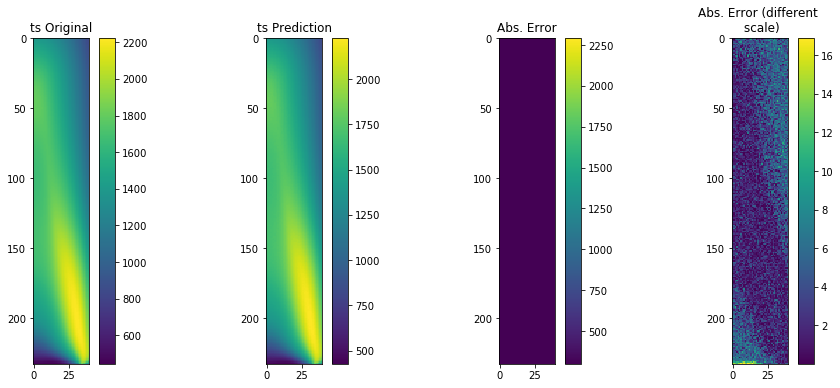

In [35]:
N = 20

plt.subplot(1, 4, 1)
plt.imshow(y_test[N])
plt.title(OUTPUT + ' Original')
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(y_test_pred[N])
plt.title(OUTPUT + ' Prediction')
plt.colorbar()

abs_err = np.abs(y_test[N] - y_test_pred[N])

plt.subplot(1, 4, 3)
plt.imshow(abs_err, vmin=y_test.min(), vmax=y_test.max())
plt.title('Abs. Error')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(abs_err)
plt.title('Abs. Error (different \n scale)')
plt.colorbar()

print('Abs. error max:', abs_err.max())
print('Abs. error min:', abs_err.min())
print('Abs. error mean:', abs_err.mean())
print('Abs. error stddev:', abs_err.std())